In [1]:
# Import necessary libraries
# =====================================================================
import os

# Configurar el nivel de logging para mostrar solo errores
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import configparser
import tensorflow as tf
import pandas as pd

# Import src code
from src.model.build_unet import build_unet
from src.utils.utils import PROJECT_DIR, DATA_PATH
from src.visualization import visualize
from src.model.overfitting_test import *
from src.data.create_dataset import dataset_tf
from src.data.path_loader import PathLoader

In [2]:
# Use the GPU
# =====================================================================
gpus_list = tf.config.list_physical_devices("GPU")
gpu = gpus_list[0]
tf.config.experimental.set_memory_growth(gpu, True)

print("GPUs Available: ", gpus_list)

GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
# Set config file
# =====================================================================
config = configparser.ConfigParser()
config.read(PROJECT_DIR / "config.ini")

# Hyperparameters
config_hp = config["hyperparameters"]

IMG_SIZE = 32
NUM_CLASSES = int(config_hp["num_classes"])
BATCH_SIZE = 128
EPOCHS = 100
T = int(config_hp["T"])  # number of diffusion steps
BETA_START = float(config_hp["beta_start"])
BETA_END = float(config_hp["beta_end"])
s = float(config_hp["s"])  # scale factor for the variance curve
SCHEDULER = config_hp["scheduler"]

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # TODO: ADD TO CONFIG FILE
loss_fn = tf.keras.losses.MeanSquaredError()

# 1. Dataset

In [4]:
# Load csv data
# =====================================================================
path = f"{DATA_PATH}/processed/pokedex_cleaned.csv"
df = pd.read_csv(path)

# Show the df
df

,name,pokedex_id,type1,type2,image_fn
0,Bulbasaur,1,Grass,Poison,['1']
1,Ivysaur,2,Grass,Poison,['2']
2,Venusaur,3,Grass,Poison,['3']
3,Venusaur Gmax,3,Grass,Poison,['3_g']
4,Venusaur Mega,3,Grass,Poison,['3_2']
...,...,...,...,...,...
1113,Glastrier,896,Ice,NaN,['896']
1114,Spectrier,897,Ghost,NaN,['897']
1115,Calyrex,898,Psychic,Grass,['898_1']
1116,Calyrex Ice Rider,898,Psychic,Ice,['898_2']


Dataset saved to file: /workspaces/tf-diffusion-scratch/data/processed/pokemon_tf_dataset
- The shape of the dataset is: (128, 32, 32, 3) => batch_size: 128, height: 32, width: 32, channels: 3
- The shape of the dataset labels is: (128, 18) => batch_size: 128, number of labels: 18


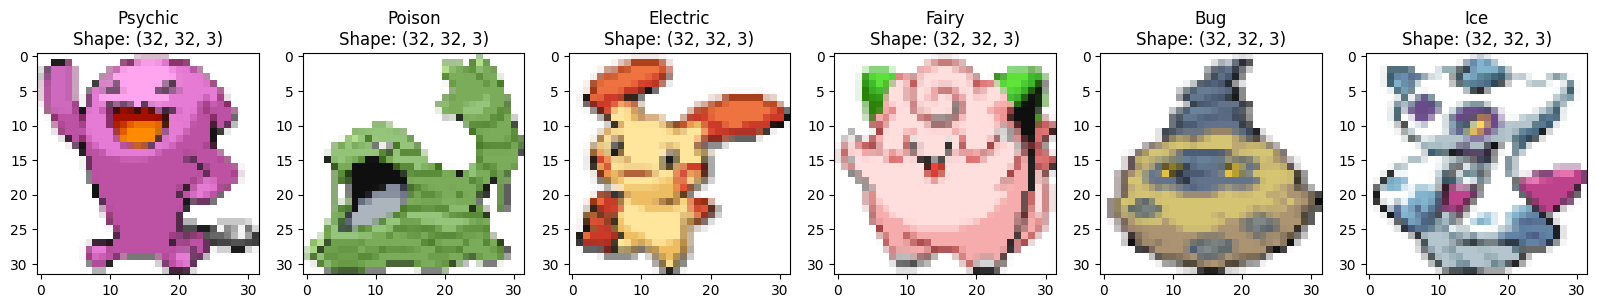

In [5]:
dataset_path = f"{DATA_PATH}/processed/pokemon_tf_dataset"
# poke_dataset = tf.data.Dataset.load(path=dataset_path, compression="GZIP")

poke_dataset = dataset_tf(
    image_paths=PathLoader.get_image_paths(f"{DATA_PATH}/interim/image_paths.json"),
    df=df,
    img_size=32,
    batch_size=128,
    save=True,
    save_path=dataset_path,
)

# Check the dataset
# =====================================================================
for img, label in poke_dataset.take(1):
    print(
        f"- The shape of the dataset is: {img.shape} => batch_size: {img.shape[0]}, height: {img.shape[1]}, width: {img.shape[2]}, channels: {img.shape[3]}"
    )
    print(
        f"- The shape of the dataset labels is: {label.shape} => batch_size: {label.shape[0]}, number of labels: {label.shape[1]}"
    )

# Visualize the dataset
visualize.plot_images_batch(dataset_tf=poke_dataset, n=6)

# 2. Model

In [6]:
# Create the model
# =====================================================================
u_net = build_unet(IMG_SIZE, NUM_CLASSES)
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model = DiffusionModel(
    u_net, IMG_SIZE, NUM_CLASSES, 500, BETA_START, BETA_END, s, "linear"
)

# Compile the model
# =====================================================================
model.compile(loss=loss_fn, optimizer=optimizer)

## 2.1. Training

Epoch 1/100


I0000 00:00:1714224156.579826   52965 service.cc:145] XLA service 0x72b3480480f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1714224156.579857   52965 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
W0000 00:00:1714224156.991418   52965 random_ops.cc:105] Warning: Using tf.random.uniform with XLA compilation will ignore seeds; consider using tf.random.stateless_uniform instead if reproducible behavior is desired. random_uniform
I0000 00:00:1714224158.445678   53143 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2982', 52 bytes spill stores, 52 bytes spill loads

I0000 00:00:1714224158.513650   53151 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_2982', 24 bytes spill stores, 40 bytes spill loads

I0000 00:00:1714224159.143718   53151 asm_compiler.cc:369] ptxas war

 2/63 ━━━━━━━━━━━━━━━━━━━━ 5s 90ms/step - loss: 1.7890  

I0000 00:00:1714224171.457126   52965 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 87ms/step - loss: 0.8843
Epoch 2/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.2739
Epoch 3/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.1750
Epoch 4/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.1731
Epoch 5/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.2305
Epoch 6/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.2242
Epoch 7/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.1620
Epoch 8/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.1933
Epoch 9/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1659
Epoch 10/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1576
Epoch 11/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1364
Epoch 12/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1132
Epoch 13/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1345
Epoch 14/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1112
Epoch 15/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1272


Sampling sprite: 500it [00:21, 23.19it/s]                         


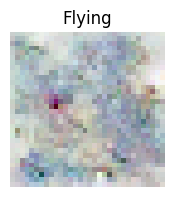

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - loss: 0.1467
Epoch 21/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.1024
Epoch 22/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.0834
Epoch 23/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.1415
Epoch 24/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1539
Epoch 25/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1199
Epoch 26/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1449
Epoch 27/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1191
Epoch 28/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1198
Epoch 29/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1343
Epoch 30/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1336
Epoch 31/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0908
Epoch 32/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1515
Epoch 33/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.1624
Epoch 34/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/ste

Sampling sprite: 500it [00:20, 24.41it/s]                         


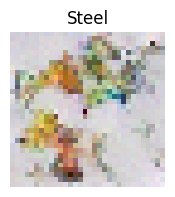

63/63 ━━━━━━━━━━━━━━━━━━━━ 27s 440ms/step - loss: 0.1281
Epoch 41/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.1348
Epoch 42/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.1799
Epoch 43/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1528
Epoch 44/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1240
Epoch 45/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1170
Epoch 46/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1312
Epoch 47/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1397
Epoch 48/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1393
Epoch 49/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1036
Epoch 50/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1569
Epoch 51/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1245
Epoch 52/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1387
Epoch 53/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1237
Epoch 54/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/s

Sampling sprite: 500it [00:21, 23.73it/s]                         


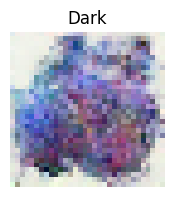

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.1050
Epoch 61/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.1170
Epoch 62/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0932
Epoch 63/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1460
Epoch 64/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1063
Epoch 65/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1188
Epoch 66/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1319
Epoch 67/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1579
Epoch 68/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1351
Epoch 69/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1135
Epoch 70/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1069
Epoch 71/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0850
Epoch 72/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1162
Epoch 73/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1028
Epoch 74/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms

Sampling sprite: 500it [00:20, 23.89it/s]                         


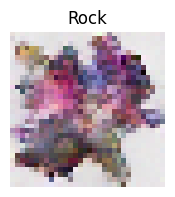

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - loss: 0.0922
Epoch 81/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1072
Epoch 82/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.1004
Epoch 83/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0929
Epoch 84/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1679
Epoch 85/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1048
Epoch 86/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0708
Epoch 87/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0820
Epoch 88/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0878
Epoch 89/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1343
Epoch 90/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0975
Epoch 91/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0835
Epoch 92/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0983
Epoch 93/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1154
Epoch 94/100
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms

Sampling sprite: 500it [00:21, 22.74it/s]                         


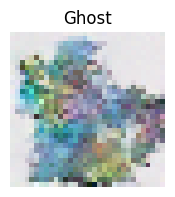

63/63 ━━━━━━━━━━━━━━━━━━━━ 29s 464ms/step - loss: 0.1036


In [7]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=EPOCHS, callbacks=[DiffusionCallback(model, 20)])

Epoch 1/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.0827
Epoch 2/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - loss: 0.1129
Epoch 3/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0862
Epoch 4/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.1067
Epoch 5/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - loss: 0.0843
Epoch 6/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1081
Epoch 7/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0842
Epoch 8/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1068
Epoch 9/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0977
Epoch 10/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0940
Epoch 11/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1063
Epoch 12/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1808
Epoch 13/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1016
Epoch 14/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1224
Epoch 15/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/ste

Sampling sprite: 500it [00:20, 24.10it/s]                         


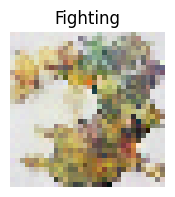

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 444ms/step - loss: 0.1087
Epoch 21/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 89ms/step - loss: 0.1288
Epoch 22/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1015
Epoch 23/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1029
Epoch 24/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.1198
Epoch 25/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0785
Epoch 26/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.1377
Epoch 27/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0980
Epoch 28/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1148
Epoch 29/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0750
Epoch 30/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1113
Epoch 31/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1119
Epoch 32/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1214
Epoch 33/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1342
Epoch 34/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/

Sampling sprite: 500it [00:21, 23.50it/s]                         


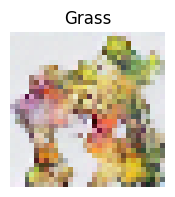

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - loss: 0.1172
Epoch 41/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 90ms/step - loss: 0.1004
Epoch 42/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.1022
Epoch 43/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0927
Epoch 44/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.1134
Epoch 45/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0692
Epoch 46/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1093
Epoch 47/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0940
Epoch 48/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1112
Epoch 49/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0919
Epoch 50/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0845
Epoch 51/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0898
Epoch 52/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0905
Epoch 53/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0801
Epoch 54/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms

Sampling sprite: 500it [00:21, 23.76it/s]                         


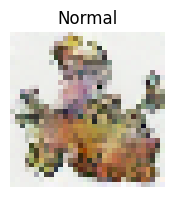

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.0585
Epoch 61/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0970
Epoch 62/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1170
Epoch 63/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0855
Epoch 64/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0879
Epoch 65/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1023
Epoch 66/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1330
Epoch 67/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0999
Epoch 68/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0878
Epoch 69/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1067
Epoch 70/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0888
Epoch 71/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1214
Epoch 72/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0923
Epoch 73/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0829
Epoch 74/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/

Sampling sprite: 500it [00:21, 23.78it/s]                         


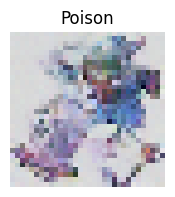

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - loss: 0.0843
Epoch 81/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1000
Epoch 82/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0696
Epoch 83/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1151
Epoch 84/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1074
Epoch 85/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1224
Epoch 86/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0820
Epoch 87/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1094
Epoch 88/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1382
Epoch 89/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0957
Epoch 90/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1026
Epoch 91/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0836
Epoch 92/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0744
Epoch 93/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1246
Epoch 94/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms

Sampling sprite: 500it [00:21, 23.67it/s]                         


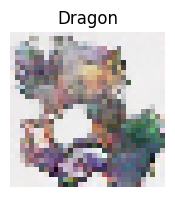

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - loss: 0.0987
Epoch 101/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0962
Epoch 102/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.0935
Epoch 103/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0641
Epoch 104/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.1131
Epoch 105/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0907
Epoch 106/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0923
Epoch 107/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1059
Epoch 108/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1216
Epoch 109/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1165
Epoch 110/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0996
Epoch 111/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1196
Epoch 112/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0678
Epoch 113/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0675
Epoch 114/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.74it/s]                         


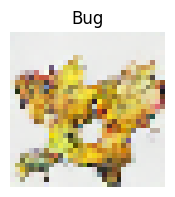

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.1245
Epoch 121/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.1156
Epoch 122/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1070
Epoch 123/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0789
Epoch 124/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0791
Epoch 125/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1086
Epoch 126/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1129
Epoch 127/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0791
Epoch 128/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1346
Epoch 129/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1266
Epoch 130/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1336
Epoch 131/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1269
Epoch 132/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0794
Epoch 133/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0881
Epoch 134/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:20, 23.83it/s]                         


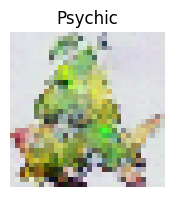

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - loss: 0.1187
Epoch 141/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.1010
Epoch 142/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0973
Epoch 143/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0615
Epoch 144/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0927
Epoch 145/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1062
Epoch 146/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0902
Epoch 147/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0908
Epoch 148/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0745
Epoch 149/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0884
Epoch 150/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1074
Epoch 151/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0819
Epoch 152/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0968
Epoch 153/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0770
Epoch 154/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:20, 23.88it/s]                         


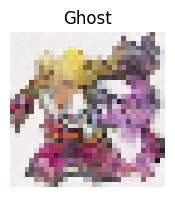

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - loss: 0.0865
Epoch 161/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0740
Epoch 162/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0762
Epoch 163/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0626
Epoch 164/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0772
Epoch 165/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1039
Epoch 166/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0865
Epoch 167/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1066
Epoch 168/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1209
Epoch 169/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1269
Epoch 170/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1339
Epoch 171/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1089
Epoch 172/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1032
Epoch 173/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0797
Epoch 174/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.66it/s]                         


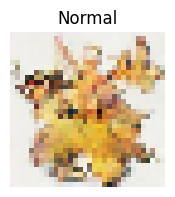

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 452ms/step - loss: 0.1088
Epoch 181/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0988
Epoch 182/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0819
Epoch 183/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0726
Epoch 184/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0969
Epoch 185/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1146
Epoch 186/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0652
Epoch 187/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0920
Epoch 188/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0904
Epoch 189/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0826
Epoch 190/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0763
Epoch 191/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0968
Epoch 192/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0851
Epoch 193/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0975
Epoch 194/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.58it/s]                         


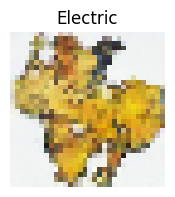

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - loss: 0.0823
Epoch 201/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0702
Epoch 202/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0752
Epoch 203/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0753
Epoch 204/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0816
Epoch 205/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.1161
Epoch 206/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0929
Epoch 207/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0940
Epoch 208/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1339
Epoch 209/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0703
Epoch 210/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0697
Epoch 211/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0914
Epoch 212/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0739
Epoch 213/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1154
Epoch 214/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.78it/s]                         


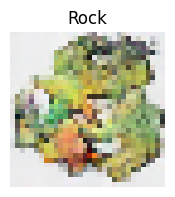

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.0954
Epoch 221/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0647
Epoch 222/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.0965
Epoch 223/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0852
Epoch 224/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0893
Epoch 225/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0958
Epoch 226/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0865
Epoch 227/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0904
Epoch 228/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1042
Epoch 229/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1034
Epoch 230/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0911
Epoch 231/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1122
Epoch 232/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1108
Epoch 233/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0993
Epoch 234/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:20, 23.91it/s]                         


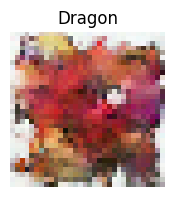

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - loss: 0.1188
Epoch 241/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0595
Epoch 242/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0800
Epoch 243/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0663
Epoch 244/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1173
Epoch 245/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1085
Epoch 246/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0774
Epoch 247/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0880
Epoch 248/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0875
Epoch 249/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0940
Epoch 250/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0946
Epoch 251/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0971
Epoch 252/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0800
Epoch 253/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0761
Epoch 254/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.76it/s]                         


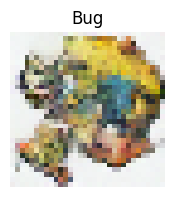

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.0779
Epoch 261/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0869
Epoch 262/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 96ms/step - loss: 0.0927
Epoch 263/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.1108
Epoch 264/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0812
Epoch 265/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1080
Epoch 266/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0878
Epoch 267/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1264
Epoch 268/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0922
Epoch 269/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0819
Epoch 270/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1154
Epoch 271/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0915
Epoch 272/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0722
Epoch 273/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0848
Epoch 274/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:20, 23.82it/s]                         


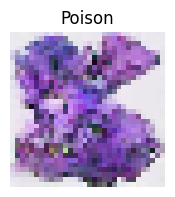

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - loss: 0.0816
Epoch 281/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0954
Epoch 282/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 97ms/step - loss: 0.1301
Epoch 283/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0946
Epoch 284/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0958
Epoch 285/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0787
Epoch 286/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0739
Epoch 287/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0895
Epoch 288/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0581
Epoch 289/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0857
Epoch 290/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0819
Epoch 291/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0763
Epoch 292/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1162
Epoch 293/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0826
Epoch 294/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.80it/s]                         


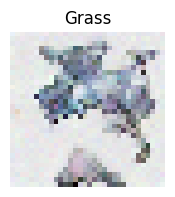

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 450ms/step - loss: 0.0898
Epoch 301/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0710
Epoch 302/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 101ms/step - loss: 0.0819
Epoch 303/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0661
Epoch 304/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0872
Epoch 305/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0728
Epoch 306/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1000
Epoch 307/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1438
Epoch 308/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0747
Epoch 309/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1030
Epoch 310/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0742
Epoch 311/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0702
Epoch 312/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0961
Epoch 313/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1066
Epoch 314/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:20, 23.86it/s]                         


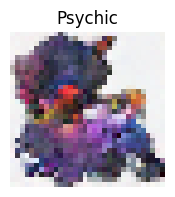

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 449ms/step - loss: 0.0777
Epoch 321/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0656
Epoch 322/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0684
Epoch 323/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0735
Epoch 324/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0705
Epoch 325/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0833
Epoch 326/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1046
Epoch 327/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0847
Epoch 328/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0979
Epoch 329/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0859
Epoch 330/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1215
Epoch 331/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1237
Epoch 332/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1222
Epoch 333/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1017
Epoch 334/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.42it/s]                         


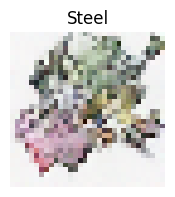

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - loss: 0.0678
Epoch 341/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0733
Epoch 342/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1008
Epoch 343/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0963
Epoch 344/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1029
Epoch 345/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1117
Epoch 346/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0986
Epoch 347/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0850
Epoch 348/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0895
Epoch 349/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0865
Epoch 350/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0820
Epoch 351/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0669
Epoch 352/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0767
Epoch 353/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0942
Epoch 354/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.43it/s]                         


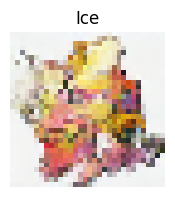

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - loss: 0.0523
Epoch 361/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0887
Epoch 362/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1107
Epoch 363/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1095
Epoch 364/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1031
Epoch 365/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1363
Epoch 366/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0800
Epoch 367/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0659
Epoch 368/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0818
Epoch 369/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1240
Epoch 370/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1134
Epoch 371/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0959
Epoch 372/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0572
Epoch 373/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0669
Epoch 374/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.53it/s]                         


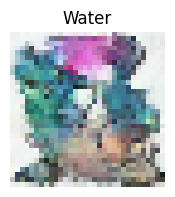

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - loss: 0.1118
Epoch 381/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - loss: 0.0932
Epoch 382/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 98ms/step - loss: 0.1156
Epoch 383/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0863
Epoch 384/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0729
Epoch 385/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0850
Epoch 386/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1097
Epoch 387/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0814
Epoch 388/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0912
Epoch 389/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0792
Epoch 390/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0778
Epoch 391/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0821
Epoch 392/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0704
Epoch 393/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0748
Epoch 394/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.75it/s]                         


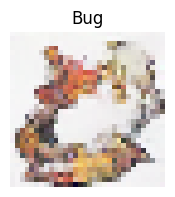

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.0660
Epoch 401/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.0914
Epoch 402/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.1024
Epoch 403/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1171
Epoch 404/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0894
Epoch 405/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1114
Epoch 406/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1208
Epoch 407/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0786
Epoch 408/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0797
Epoch 409/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0995
Epoch 410/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0683
Epoch 411/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0877
Epoch 412/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0823
Epoch 413/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0813
Epoch 414/500
63/63 ━━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.64it/s]                         


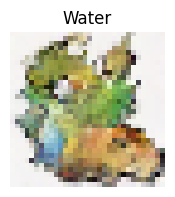

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 453ms/step - loss: 0.0859
Epoch 421/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 92ms/step - loss: 0.1183
Epoch 422/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 102ms/step - loss: 0.0726
Epoch 423/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0809
Epoch 424/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0714
Epoch 425/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0857
Epoch 426/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0785
Epoch 427/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0818
Epoch 428/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1014
Epoch 429/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0999
Epoch 430/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1028
Epoch 431/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0860
Epoch 432/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0977
Epoch 433/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1030
Epoch 434/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.43it/s]                         


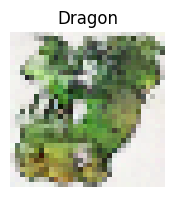

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 455ms/step - loss: 0.0824
Epoch 441/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 95ms/step - loss: 0.0918
Epoch 442/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0821
Epoch 443/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0826
Epoch 444/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0947
Epoch 445/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0843
Epoch 446/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0971
Epoch 447/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0775
Epoch 448/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0735
Epoch 449/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0833
Epoch 450/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1269
Epoch 451/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1004
Epoch 452/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0717
Epoch 453/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0779
Epoch 454/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.76it/s]                         


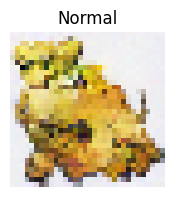

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 451ms/step - loss: 0.1014
Epoch 461/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - loss: 0.0911
Epoch 462/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 100ms/step - loss: 0.0890
Epoch 463/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - loss: 0.0865
Epoch 464/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0614
Epoch 465/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0731
Epoch 466/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0794
Epoch 467/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0919
Epoch 468/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0751
Epoch 469/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1002
Epoch 470/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1190
Epoch 471/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1109
Epoch 472/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0711
Epoch 473/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0805
Epoch 474/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.56it/s]                         


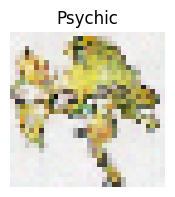

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 454ms/step - loss: 0.1277
Epoch 481/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 99ms/step - loss: 0.0656
Epoch 482/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step - loss: 0.0773
Epoch 483/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0776
Epoch 484/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0836
Epoch 485/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0704
Epoch 486/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0631
Epoch 487/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.1115
Epoch 488/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1048
Epoch 489/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0924
Epoch 490/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0727
Epoch 491/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0833
Epoch 492/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0667
Epoch 493/500
63/63 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.0777
Epoch 494/500
63/63 ━━━━━━━━━━━━━━

Sampling sprite: 500it [00:21, 23.41it/s]                         


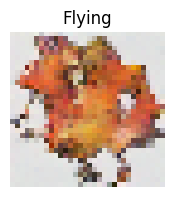

63/63 ━━━━━━━━━━━━━━━━━━━━ 28s 456ms/step - loss: 0.1273


In [12]:
# tf.config.run_functions_eagerly(True)  # to debug the model
model.fit(poke_dataset, epochs=500, callbacks=[DiffusionCallback(model, 20)])

Generating sample 1/3


Sampling sprite: 500it [00:20, 23.86it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 23.94it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.30it/s]                         


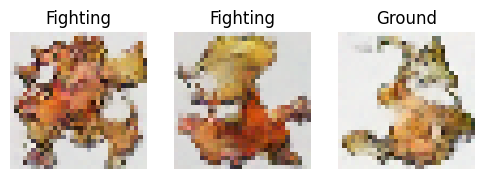

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.37it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.38it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.84it/s]                         


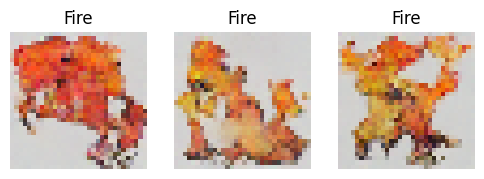

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.42it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.45it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.48it/s]                         


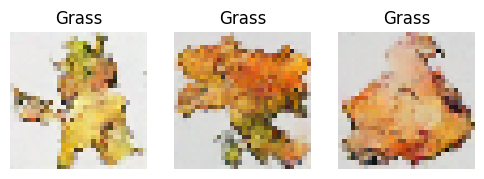

Generating sample 1/3


Sampling sprite: 500it [00:20, 24.59it/s]                         


Generating sample 2/3


Sampling sprite: 500it [00:20, 24.55it/s]                         


Generating sample 3/3


Sampling sprite: 500it [00:20, 24.57it/s]                         


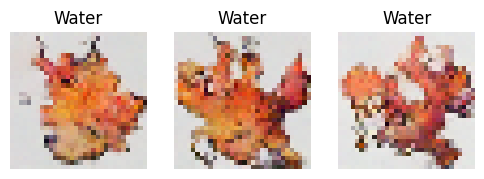

In [13]:
model.plot_samples(3)

model.plot_samples(3, "Fire")
model.plot_samples(3, "Grass")
model.plot_samples(3, "Water")

In [9]:
# import gradio as gr

# poke_diffusion = gr.Interface(
#     fn=model.plot_samples,
#     inputs=gr.Slider(minimum=1, maximum=10, label="Number of samples"),
#     outputs=gr.Image(),
# )

# poke_diffusion.launch(share=True)

## 2.2. Save Model

Finalmente, se guardan los resultados finales del modelo de difusión en un fichero `.h5` para su posterior uso y visualización. TODO: MIRAR OTROS FORMATOS DE GUARDADO

TODO: INVESTIGAR OTROS FORMATOS DE GUARDADO (HDF5, PICKLE, ETC.)

In [10]:
# Save the model function
# =====================================================================
def save_model(model: tf.keras.models.Model, model_name: str) -> None:
    """Saves the model

    :param model: The model to save
    :param model_name: The name of the model
    :return: None
    """

    # Save the model
    model_dir = "./diffusion_models/models/"
    os.makedirs(model_dir, exist_ok=True)
    if not os.path.exists(os.path.join(model_dir, f"{model_name}.h5")):
        model.save(os.path.join(model_dir, f"{model_name}.h5"))
        print(f"Model {model_name}, saved successfully!")
    else:
        print(f"Model {model_name}, already exists!")

In [11]:
# Save the model
# model_name = f"diffusion_{IMG_SIZE}_{BATCH_SIZE}_{EPOCHS}_{T}_{scheduler}_ddpm"

# save_model(model, model_name)

[BACK TO TOP](#top)